# Cuarto Examen Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### **Librerías**

In [778]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb 
from xgboost import  XGBRegressor, XGBClassifier, plot_importance as xgb_plot_importance, callback as xgb_callback
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor,LGBMClassifier, plot_importance,early_stopping, log_evaluation
import shap 
import shap.plots
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import display




warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

# **Primera Parte**

---

### **Dataset** 
Hr_role

In [779]:
df = pd.read_csv('Hr_role.csv')

### **Visualización del Dataset**

In [780]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [781]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,6502.931293,14313.103401,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,4707.956783,7117.786044,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1009.000000,2094.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2911.000000,8047.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,4919.000000,14235.500000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,8379.000000,20461.500000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,19999.000000,26999.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### **Explicación de las variables**

---

### **Dummies**

In [782]:
df = pd.get_dummies(df, drop_first=True)

In [783]:
df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,5993,19479,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,3,61,2,2,5130,24907,...,False,False,False,False,True,False,False,True,False,False
2,37,1373,2,2,4,92,2,1,2090,2396,...,True,False,False,False,False,False,False,False,True,True
3,33,1392,3,4,4,56,3,1,2909,23159,...,False,False,False,False,True,False,False,True,False,True
4,27,591,2,1,1,40,3,1,3468,16632,...,True,False,False,False,False,False,False,True,False,False


---

### **NaN's**

In [784]:
pd.DataFrame(df.isnull().sum()).T

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Si es que hay, usamos la mediana para rellenar

In [785]:
'''
df['--'] = df['--'].fillna(df['--'].median())
'''

"\ndf['--'] = df['--'].fillna(df['--'].median())\n"

##### Comprobamos que ya no haya NaN's

In [786]:
pd.DataFrame(df.isnull().sum()).T

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

### **Funciones**

##### Función Calibración 

In [787]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

##### Función KMeans

In [788]:
def kmeans(df, columnas, max_clusters=80):
    X = df[columnas].values

    inertias = []
    
    for k in range(1, max_clusters + 1):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=k, random_state=42))
        ])
        pipeline.fit(X)
        inertia = pipeline.named_steps['kmeans'].inertia_
        inertias.append(inertia)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.grid(True)
    plt.show()


##### Función Clusters

In [789]:
def clusters(df, clusters, comp_x='PC1', comp_y='PC2'):
    df = df.copy().dropna()

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=clusters, random_state=42))
    ])

    pipeline.fit(df)
    df['cluster'] = pipeline.predict(df)

    pca = PCA(n_components=max(6, clusters))
    X_pca = pca.fit_transform(df)

    x_components = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    x_components['Cluster'] = df['cluster'] + 1

    plt.figure(figsize=(8, 6))
    plt.scatter(x_components[comp_x], x_components[comp_y], c=x_components['Cluster'])
    plt.xlabel(comp_x)
    plt.ylabel(comp_y)
    plt.title(f'Con {clusters} Clusters visualizados en {comp_x} y {comp_y}')
    plt.show()



##### Función PCA

In [790]:
def pca(X, n_var=None):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])

    pipeline.fit(X)
    pca_model = pipeline.named_steps['pca']

    X_pca = pipeline.transform(X)
    x_components = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    plt.plot(pca_model.explained_variance_ratio_, marker='o')
    plt.title('Varianza explicada por componente')
    plt.xlabel('Componente principal')
    plt.ylabel('Varianza explicada')
    plt.grid(True)
    plt.show()

    display((x_components).head())
    return pca_model, pipeline

##### Función PCA Varianza

In [791]:
def var_pca(X, n_var):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_var)) 
    ])

    pipeline.fit(X)
    objeto_pca = pipeline.named_steps['pca']

    X_pca = pipeline.transform(X)
    x_components = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    plt.plot(objeto_pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Componente Principal')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza Explicada por Componente')
    plt.grid(True)
    plt.show()

    varianza = pd.DataFrame({
        f'PC{i+1}': objeto_pca.explained_variance_ratio_[i] for i in range(n_var)
    }, index=['Varianza']).T

    display(varianza)

    return x_components.head()




##### Función Gráfica n PCA

In [792]:
def plot_pca(X, comp_x='PC1', comp_y='PC2'):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])

    pipeline.fit(X)
    objeto_pca = pipeline.named_steps['pca']

    X_pca = pipeline.transform(X)
    x_components = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    
    if comp_x not in x_components.columns or comp_y not in x_components.columns:
        raise ValueError(f"Componentes inválidas: {comp_x}, {comp_y}. Usa nombres como 'PC1', 'PC2', etc.")

    plt.figure(figsize=(8, 6))
    plt.scatter(x_components[comp_x], x_components[comp_y], alpha=1)
    plt.xlabel(comp_x)
    plt.ylabel(comp_y)
    plt.title(f'PCA - Proyección en {comp_x} y {comp_y}')
    plt.grid(True)
    plt.show()


##### Función LightGBM

In [793]:
def lightgbm(X_train, y_train, X_test, y_test):
    model_lightgbm = LGBMClassifier(
        n_estimators=1000000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=50,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.5,
        verbosity=-1
    )
    model_lightgbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=200)
        ]
    )
    proba_lightgbm = model_lightgbm.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, proba_lightgbm)
   
    fpr, tpr, _ = roc_curve(y_test, proba_lightgbm)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - XGBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': proba_lightgbm
    })

    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades XGBoost')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()


    importancia = pd.DataFrame({
        'variables': X_train.columns,
        'importancia': model_lightgbm.feature_importances_
    })
    importancia.sort_values('importancia', ascending=True, inplace=True)
    importancia0 = importancia.tail(5)
    importancia0.plot.barh(x='variables', y='importancia', figsize=(8,6))
    plt.xlabel('Importancia')
    plt.title('Top 5 Feature Importances')
    plt.grid(True)
    plt.show()
    
    print("AUC XGBoost:", auc_score)




##### Función Shap LightGBM

In [794]:
def shapLGBM(X_train, y_train, X_test, y_test):
    model_lightgbm = LGBMClassifier(
        n_estimators=1000000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=50,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.5,
        verbosity=-1
    )
    model_lightgbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=200)
        ]
    )
    proba_lightgbm = model_lightgbm.predict_proba(X_test)[:, 1]
    
    auc_score = roc_auc_score(y_test, proba_lightgbm)
    print(f"AUC XGBoost: {auc_score:.4f}")

    sample_size = min(10000, len(X_test))
    X_shap = X_test.sample(sample_size, random_state=42)

    explainer = shap.TreeExplainer(model_lightgbm)
    shap_values = explainer.shap_values(X_shap)

    shap.initjs()

    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_shap.iloc[0],
        feature_names=X_shap.columns
    ))

    plt.title('Top 5 Variables más importantes (Barplot)')
    shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=5)

    plt.title('Top 10 Variables con mayor impacto (Dotplot)')
    shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=10)


##### Función LightGBM/PCA
 

In [795]:
def pcaLGBM(X_train, y_train, X_test, y_test, componentes):

    X_train_sel = X_train[componentes]
    X_test_sel = X_test[componentes]

    model_pcaLGBM = LGBMClassifier(
        n_estimators=10000,
        num_leaves=10,
        learning_rate=0.2,
        max_depth=100,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.5,
        verbosity=-1
    )
    
    model_pcaLGBM.fit(
        X_train_sel, y_train,
        eval_set=[(X_train_sel, y_train), (X_test_sel, y_test)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100)
        ]
    )
    
    proba_pcaLGM = model_pcaLGBM.predict_proba(X_test_sel)[:, 1]
    auc_score = roc_auc_score(y_test, proba_pcaLGM)

    fpr, tpr, _ = roc_curve(y_test, proba_pcaLGM)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    calibracion(proba_pcaLGM, y_test, 10)
    
    juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': proba_pcaLGM
    })
    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades LightGBM')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    importancia = pd.DataFrame({
        'variables': X_train_sel.columns,
        'importancia': model_pcaLGBM.feature_importances_
    })
    importancia.sort_values('importancia', ascending=True, inplace=True)
    importancia.tail(5).plot.barh(x='variables', y='importancia', figsize=(8,6))
    plt.xlabel('Importancia')
    plt.title('Top 5 Feature Importances')
    plt.grid(True)
    plt.show()

    
    
    print("AUC:", auc_score)


---

### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

In [796]:
target= 'Attrition_Yes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---

#### **Correlación del target con todas las variables**

In [797]:
df.corr()['Attrition_Yes'].sort_values(ascending=False)

Attrition_Yes                        1.000000
OverTime_Yes                         0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
JobRole_Human Resources              0.036215
Gender_Male                          0.029453
JobRole_Sales Executive              0.019774
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other                -0.017898
Education                           -0.031373
EducationField_Life Sciences      

In [798]:
df.drop('StandardHours', axis=1, inplace=True)

---

## **Modelos**

### PCA

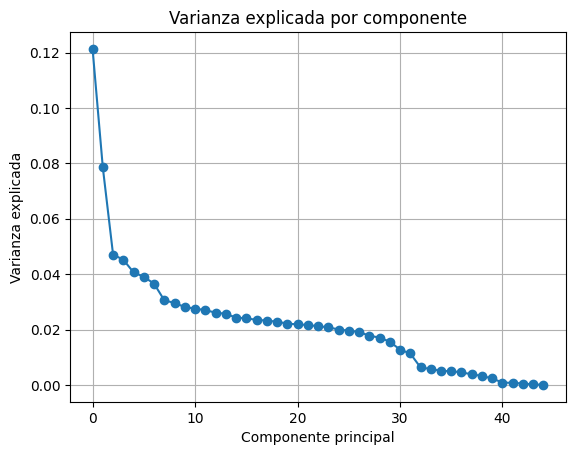

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,-0.032572,2.291182,0.793191,-2.052578,-0.317374,-0.110203,2.249507,1.243813,0.886021,-1.572228,...,-0.126584,0.164934,0.039706,0.550329,0.121724,0.061854,-0.023872,-0.017401,0.008032,-3.385597e-16
1,0.095676,-1.574597,0.688515,2.745892,2.795041,1.505989,0.814421,0.308180,-0.935298,0.041763,...,-0.480337,0.036832,-0.153900,0.214914,0.598078,-0.058448,-0.091334,-0.002346,-0.010296,7.943563e-16
2,-2.866842,-1.005022,0.511254,-2.039444,-0.191831,-0.796215,-0.349952,-0.806574,1.155798,2.828999,...,-0.419048,0.220208,0.336070,0.033592,-0.136736,-0.063498,-0.079978,-0.031230,0.016695,7.227427e-16
3,-1.216678,-1.138875,0.708268,1.148569,-1.043963,2.524247,1.022541,1.814230,-1.364917,-0.612262,...,0.576902,-0.284522,0.362471,0.070388,-0.059998,0.021935,0.037192,0.004840,-0.012791,8.588709e-16
4,-2.077853,-1.222251,-1.604687,-0.578037,-1.086934,-0.129475,-1.866160,-1.622411,1.374715,0.181979,...,0.092113,0.139018,0.051712,-0.035541,0.045509,0.059128,0.134617,-0.008344,-0.031498,-3.318212e-15


(PCA(), Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())]))

In [799]:
pca(X,1)

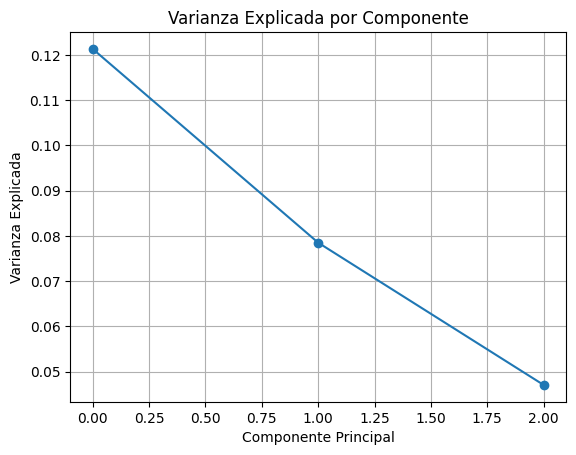

,Varianza
PC1,0.121305
PC2,0.078496
PC3,0.047062


,PC1,PC2,PC3
0,-0.032572,2.291182,0.793191
1,0.095676,-1.574597,0.688515
2,-2.866842,-1.005022,0.511254
3,-1.216678,-1.138875,0.708268
4,-2.077853,-1.222251,-1.604687


In [800]:
var_pca(X,3)

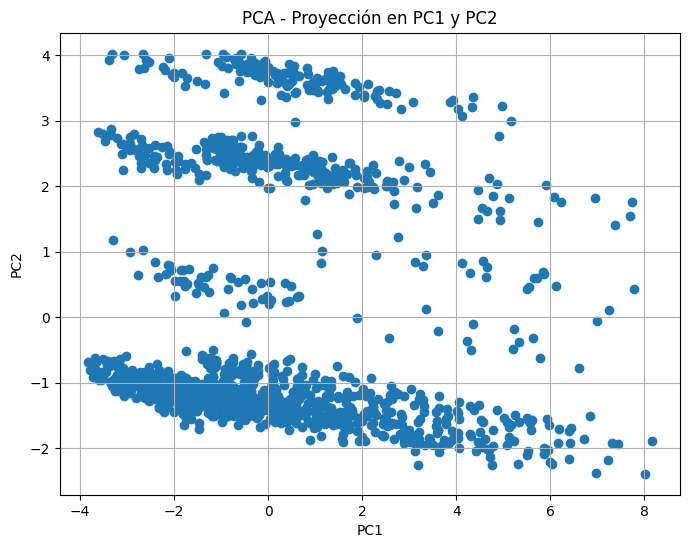

In [801]:
plot_pca(X, 'PC1', 'PC2')

---

### KMeans

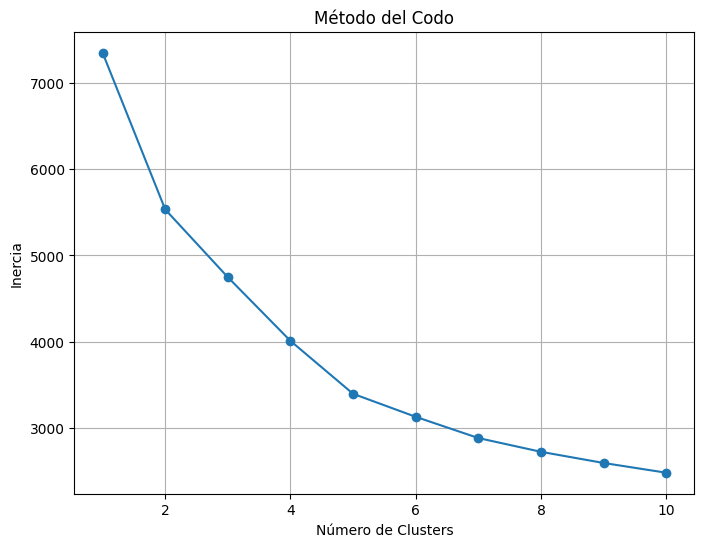

In [802]:
kmeans(X, ['DistanceFromHome', 'Age', 'NumCompaniesWorked', 'TotalWorkingYears', 'TrainingTimesLastYear'], 10)


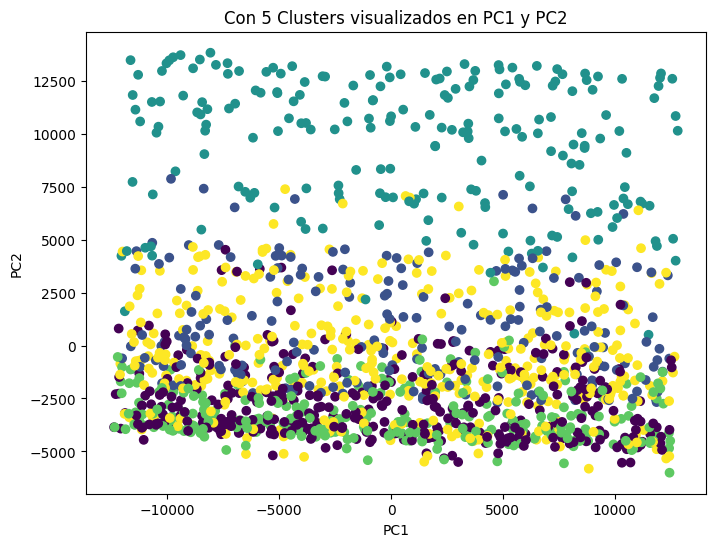

In [803]:
clusters(X, 5, 'PC1', 'PC2')

---

### LightGBM

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0563464	valid_1's auc: 0.782582	valid_1's binary_logloss: 0.410293
Early stopping, best iteration is:
[59]	training's auc: 0.983677	training's binary_logloss: 0.181705	valid_1's auc: 0.80429	valid_1's binary_logloss: 0.351961


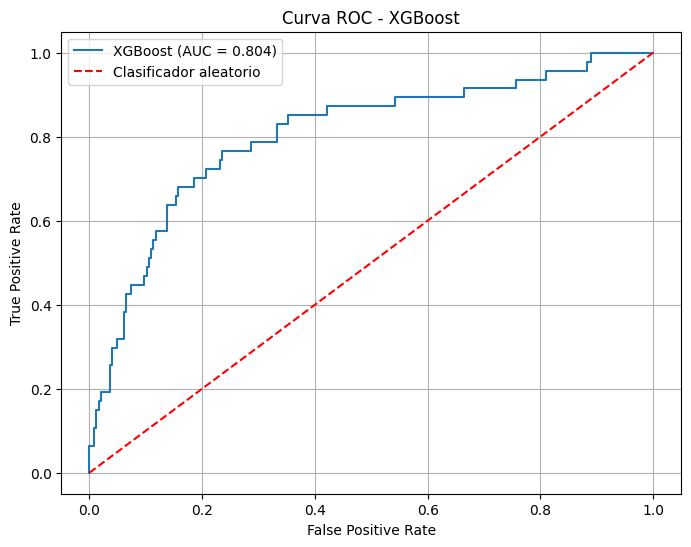

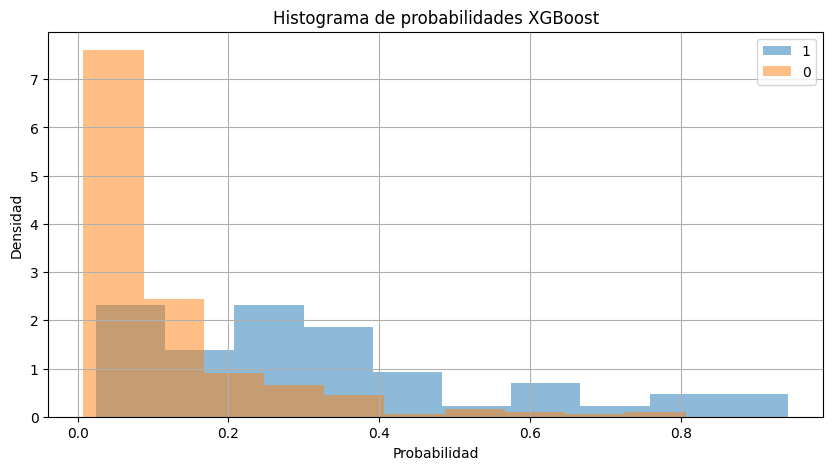

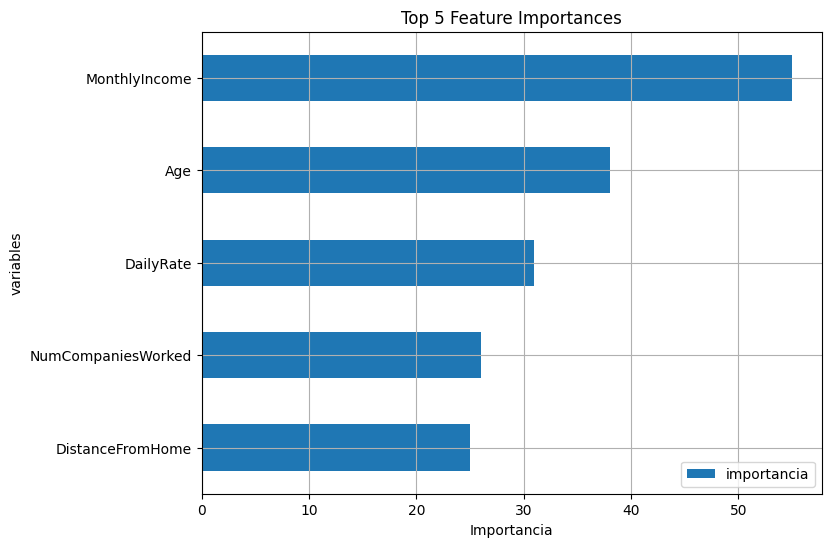

AUC XGBoost: 0.8042897751744337


In [804]:
lightgbm(X_train, y_train, X_test, y_test)

### Shap LightGBM

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0563464	valid_1's auc: 0.782582	valid_1's binary_logloss: 0.410293
Early stopping, best iteration is:
[59]	training's auc: 0.983677	training's binary_logloss: 0.181705	valid_1's auc: 0.80429	valid_1's binary_logloss: 0.351961
AUC XGBoost: 0.8043


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


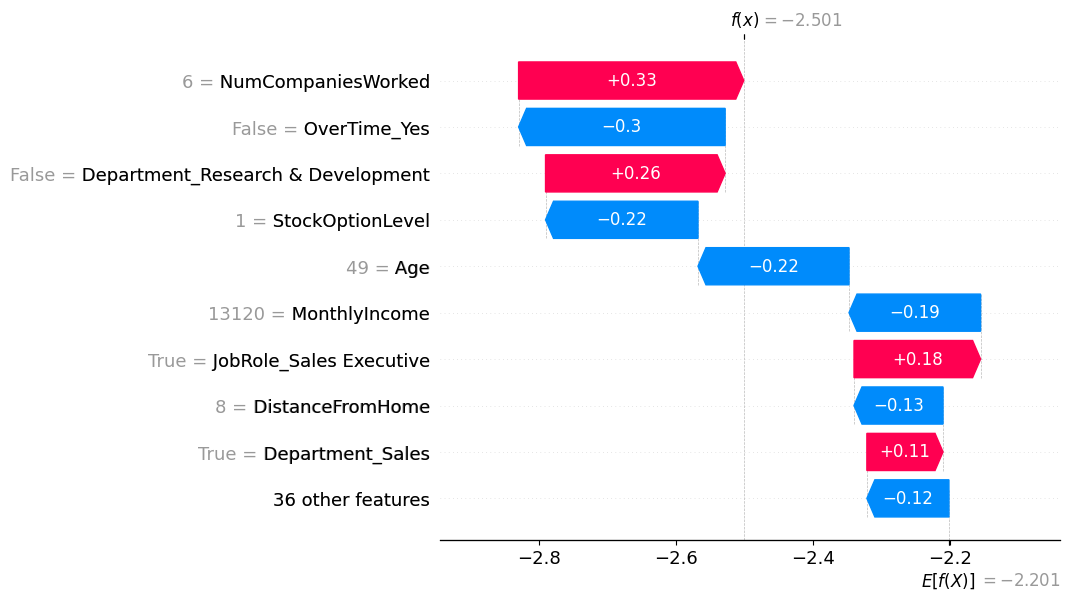

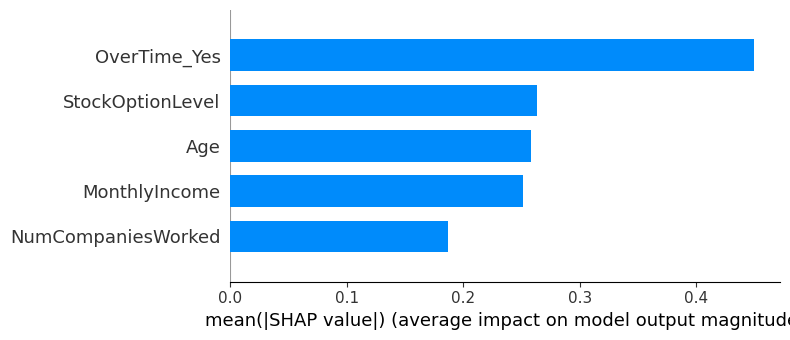

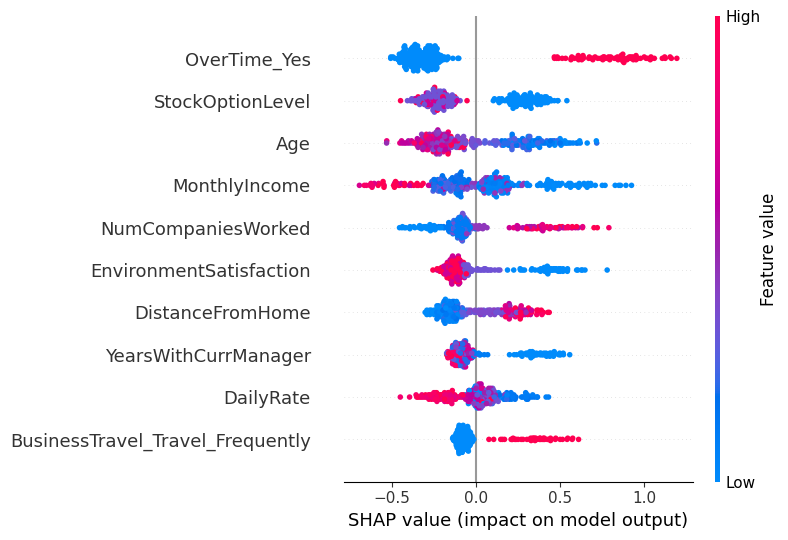

In [805]:
shapLGBM(X_train, y_train, X_test, y_test)

### LightGBM PCA

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.967789	training's binary_logloss: 0.214189	valid_1's auc: 0.556896	valid_1's binary_logloss: 0.537562
Early stopping, best iteration is:
[5]	training's auc: 0.805386	training's binary_logloss: 0.372458	valid_1's auc: 0.623869	valid_1's binary_logloss: 0.427031


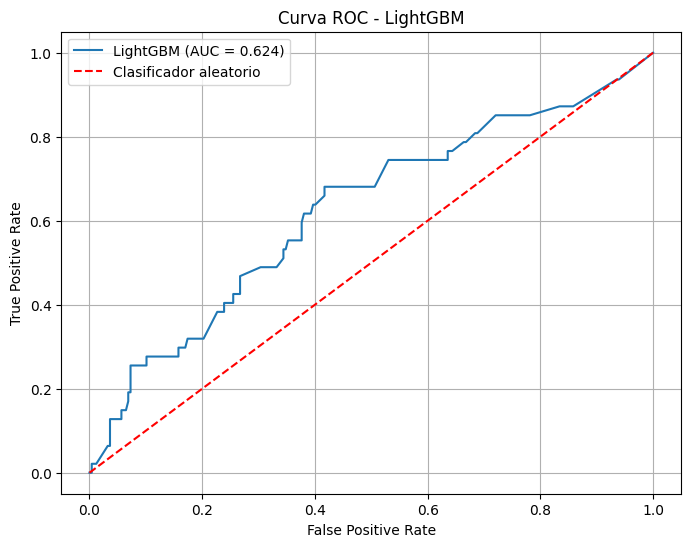

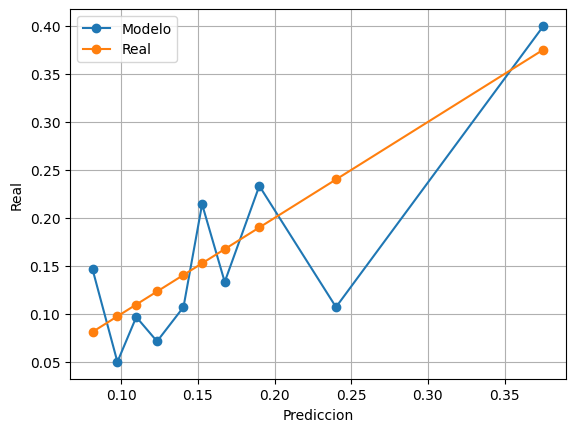

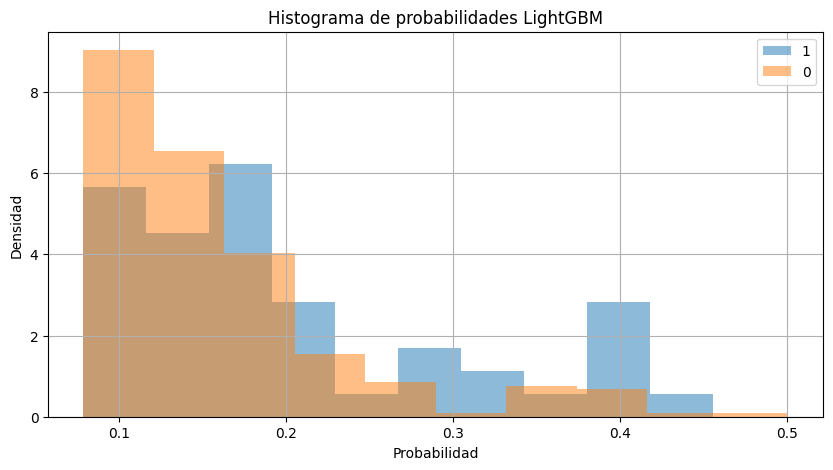

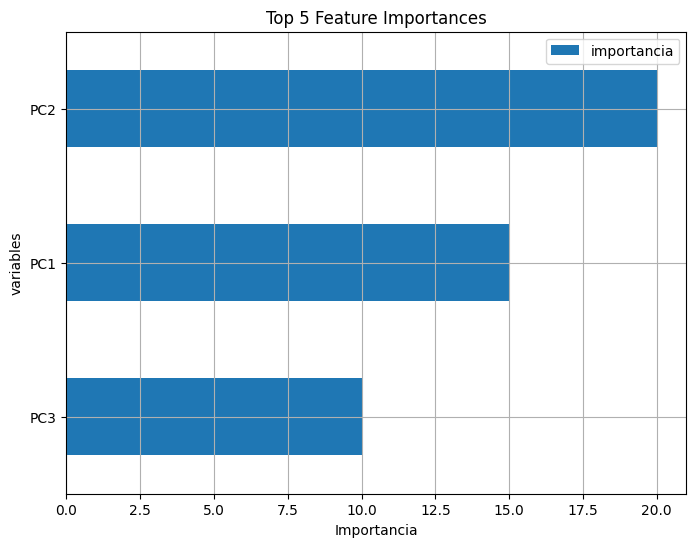

AUC: 0.6238694116633646


In [806]:
pcaLGBM(x_comp_train, y_train, x_comp_test, y_test, ['PC1','PC2','PC3'])

---

# **Parte 2**

---

### **Dataset** 
Diabetes

In [807]:
df = pd.read_csv('Diabetes.csv')

### **Visualización del Dataset**

In [808]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [809]:
df.describe()

,age,hypertension,heart_disease,bmi,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,0.085000
std,22.516840,0.26315,0.194593,6.636783,0.278883
min,0.080000,0.00000,0.000000,10.010000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,0.000000
max,80.000000,1.00000,1.000000,95.690000,1.000000


### **Explicación de las variables**

`gender`: Básicamente indica el sexo biológico del paciente.

`age`: Edad

`hypertension`: Dice si tiene hipertensión o no.


`heart_disease`: Dice si tiene una enfermedad en el corazón o no.

`smoking_history`: Dice si ha fumado o no.

`never`: Nunca ha fumado.

`current`: Actualmente fuma.

`No Info`: No se tiene información sobre su historial de tabaquismo.

`bmi`: Un indicador del peso en relación a la altura.

`diabetes`: Dice si tiene diabetes o no.

---

### **Dummies**

In [810]:
df = pd.get_dummies(df, drop_first=True)

In [811]:
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False


---

### **NaN's**

In [812]:
pd.DataFrame(df.isnull().sum()).T

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,0,0,0,0,0,0,0,0,0,0,0


##### Si es que hay, usamos la mediana para rellenar

In [813]:
'''
df['--'] = df['--'].fillna(df['--'].median())
'''

"\ndf['--'] = df['--'].fillna(df['--'].median())\n"

##### Comprobamos que ya no haya NaN's

In [814]:
pd.DataFrame(df.isnull().sum()).T

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,0,0,0,0,0,0,0,0,0,0,0


---

### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

In [815]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---

### **Correlación del target con todas las variables**

In [816]:
df.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
age                            0.258008
bmi                            0.214357
hypertension                   0.197823
heart_disease                  0.171727
smoking_history_former         0.097917
gender_Male                    0.037666
smoking_history_never          0.027267
smoking_history_ever           0.024080
smoking_history_not current    0.020734
smoking_history_current        0.019606
gender_Other                  -0.004090
Name: diabetes, dtype: float64

In [817]:
df.drop('gender_Other', axis=1, inplace=True)

---

## **Modelos**

### S learner

### X learner

### Tlearner

---

## **Conclusión**